In [1]:
import os 
import sys
import shutil
import glob
import importlib
#from pathlib import Path
import random

import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
#from sklearn.model_selection import train_test_split
from pysiib import SIIB

import IPython

repos_dir = r'/home/akikun/repos'
sys.path.append(repos_dir)
from sak import display as dp
from sak import signal_processing as sp
from sak import nele

repos_imgan_dir = os.path.join(repos_dir, 'Intelligibility-MetricGAN')
sys.path.append(repos_imgan_dir)
import default_settings as default
#import audio_util as au

In [2]:
def SIIB_Wrapper(x, y, fs):
    minL = min(len(x), len(y))
    x = x[:minL]
    y = y[:minL]
    M = len(x)/fs
    if(M<20):
        x = np.hstack([x]*round(50/M))
        y = np.hstack([y]*round(50/M))
    #return mapping_func_jr(SIIB(x,y,fs,gauss=True))
    return SIIB(x, y, fs, gauss=True)

    
def read_SIIB(clean_file, noise_file, enhanced_file, sampling_frequency=44100):
    clean_wav    = sp.load_wav(clean_file)     
    noise_wav    = sp.load_wav(noise_file)     
    enhanced_wav = sp.load_wav(enhanced_file)
    
    minL = min(len(clean_wav),len(enhanced_wav))
    clean_wav = clean_wav[:minL]
    noise_wav = noise_wav[:minL]
    enhanced_wav = enhanced_wav[:minL]
    
    siib_score = SIIB_Wrapper(clean_wav, enhanced_wav + noise_wav, sampling_frequency)  
    return siib_score

In [3]:
def siib_ssdrc():
    n_epoch = 1
    imgan_dir = os.path.join(default.output_path, 'epoch' + str(n_epoch), 'Test_epoch' + str(n_epoch))
    wav_imgan_paths = glob.glob(os.path.join(imgan_dir, '*.wav'))

    siib_scores = []
    wav_imgan_paths.sort()
    for i, wav_imgan_path in enumerate(wav_imgan_paths, start=1):
        wav_basename = os.path.basename(wav_imgan_path)

        wav_id = wav_basename.split('_snr')[0] + '.wav'
        snr_str = wav_basename.split('_snr')[1].split('@')[0]
        snr = int(snr_str)

        wav_clean_path = os.path.join(per_snr_dir, 'test', 'clean', wav_id)
        wav_noise_path = os.path.join(per_snr_dir, 'test', 'noise'+snr_str, wav_id)
        wav_ssdrc_path = os.path.join(ssdrc_dir, wav_id)


        # calculate SIIB.    
        print('\r' + '{}/{}'.format(i, len(wav_imgan_paths)), end="")
        siib_score = read_SIIB(wav_clean_path, wav_noise_path, wav_ssdrc_path)

        siib_scores.append([snr, siib_score])
    return pd.DataFrame(siib_scores, columns = ['snr', 'siib'])
    
    
def siib_imgan(n_epoch):
    imgan_dir = os.path.join(default.output_path, 'epoch' + str(n_epoch), 'Test_epoch' + str(n_epoch))
    wav_imgan_paths = glob.glob(os.path.join(imgan_dir, '*.wav'))

    siib_scores = []
    wav_imgan_paths.sort()
    for i, wav_imgan_path in enumerate(wav_imgan_paths, start=1):
        wav_basename = os.path.basename(wav_imgan_path)

        wav_id = wav_basename.split('_snr')[0] + '.wav'
        snr_str = wav_basename.split('_snr')[1].split('@')[0]
        snr = int(snr_str)

        wav_clean_path = os.path.join(per_snr_dir, 'test', 'clean', wav_id)
        wav_noise_path = os.path.join(per_snr_dir, 'test', 'noise'+snr_str, wav_id)
        #wav_ssdrc_path = os.path.join(ssdrc_dir, wav_id)

        print('\r' + '{}/{}'.format(i, len(wav_imgan_paths)), end="")
        #print('{} (SNR:{})'.format(wav_id, snr))
    #     print('clean: {} (exists: {})'.format(wav_clean_path, os.path.exists(wav_clean_path)))
    #     print('noise: {} (exists: {})'.format(wav_noise_path, os.path.exists(wav_noise_path)))
    #     print('imgan: {}'.format(wav_imgan_path))
    #     print('ssdrc: {} (exists: {})'.format(wav_ssdrc_path, os.path.exists(wav_ssdrc_path)))

    #     print('iMetricGAN')
    #     dp.disp_wav_file(wav_imgan_path)
    #     print('SSDRC')
    #     dp.disp_wav_file(wav_ssdrc_path)

        # calculate SIIB.    
        siib_score = read_SIIB(wav_clean_path, wav_noise_path, wav_imgan_path)
        #siib_ssdrc = read_SIIB(wav_clean_path, wav_noise_path, wav_ssdrc_path)
        #print('iMetricGAN: {}'.format(siib_imgan))
        #print('SSDRC: {}'.format(siib_ssdrc))

        siib_scores.append([snr, siib_score])
    return pd.DataFrame(siib_scores, columns = ['snr', 'siib'])

In [4]:
def calc_mean_siib_score(siib_scores, snr):
    siib_scores_ = siib_scores[siib_scores['snr']==snr]
    if len(siib_scores_) > 0:
        siib_mean_score = np.mean(siib_scores_['siib'])
    else:
        siib_mean_score = -1
    return siib_mean_score

snrs = [10, 5, 0, -5, -10]
def calc_mean_siib_scores(siib_scores):
    siib_mean_scores = []
    for snr in snrs:
        siib_mean_score = calc_mean_siib_score(siib_scores, snr)
        siib_mean_scores.append([snr, siib_mean_score])
    return siib_mean_scores 

In [14]:
# directory settings.
nele_dir = r'/home/common/db/audio_corpora/nele'
per_snr_dir = os.path.join(nele_dir, 'imgan', 'per_snr')
ssdrc_dir   = os.path.join(nele_dir, 'hikari_tts', 'wavs_ssdrc')
samples_dir = os.path.join(default.main_dir, 'samples')
out_dir = os.path.join(samples_dir, 'ssdrc_vs_imgan')

In [6]:
# calculate the siib in test data.
siib_scores_ssdrc = siib_ssdrc()
siib_scores_imgan_a = siib_imgan(5)  # 1st snr
siib_scores_imgan_b = siib_imgan(13) # 2nd snr

20/20

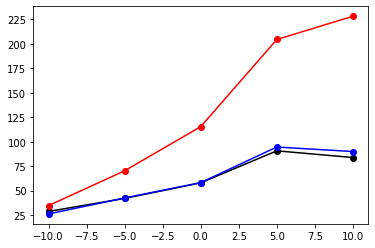

In [10]:
scores_imgan_a = calc_mean_siib_scores(siib_scores_imgan_a)
scores_imgan_b = calc_mean_siib_scores(siib_scores_imgan_b)
scores_ssdrc = calc_mean_siib_scores(siib_scores_ssdrc)
plt.plot(snrs, np.array(scores_imgan_a)[:, 1], 'ko-')
plt.plot(snrs, np.array(scores_imgan_b)[:, 1], 'bo-')
plt.plot(snrs, np.array(scores_ssdrc)[:, 1], 'ro-')

In [15]:
## make listening test samples.
n_epoch = 13
imgan_dir = os.path.join(default.output_path, 'epoch' + str(n_epoch), 'Test_epoch' + str(n_epoch))
wav_imgan_paths = glob.glob(os.path.join(imgan_dir, '*.wav'))
wav_imgan_paths.sort()
for i, wav_imgan_path in enumerate(wav_imgan_paths[0:2], start=1):
    wav_basename = os.path.basename(wav_imgan_path)

    wav_id = wav_basename.split('_snr')[0] + '.wav'
    snr_str = wav_basename.split('_snr')[1].split('@')[0]
    snr = int(snr_str)